<a href="https://colab.research.google.com/github/sigma0-advx/sigma-zero/blob/main/notebooks/sigmazero_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Change directory to your project folder
project_path = '/content/drive/MyDrive/simple_script'
os.chdir(project_path)

Mounted at /content/drive/


In [ ]:
!pip install git+https://github.com/RobustBench/robustbench.git
!pip install git+https://github.com/jeromerony/adversarial-library
!pip install git+https://github.com/Harry24k/adversarial-attacks-pytorch.git
!pip install foolbox

  Cloning https://github.com/RobustBench/robustbench.git to /tmp/pip-req-build-a5kr8xgf
  Running command git clone --filter=blob:none --quiet https://github.com/RobustBench/robustbench.git /tmp/pip-req-build-a5kr8xgf
  Resolved https://github.com/RobustBench/robustbench.git to commit 47bf370c2328bb4b78425ea06574bafec1ea7b42
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/fra31/auto-attack.git (to revision a39220048b3c9f2cca9a4d3a54604793c68eca7e) to /tmp/pip-install-seh79ert/autoattack_116420b2341f40f98039ec9e123c31bd
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack.git /tmp/pip-install-seh79ert/autoattack_116420b2341f40f98039ec9e123c31bd
  Running command git rev-parse -q --verify 'sha^a39220048b3c9f2cca9a4d3a54604793c68eca7e'
  Running command git fetch -q https://github.com/fra31/auto-attack.git a39220048b3c9f2cca9a4d3a54604793c68eca7e
  Resolved https://github.com/fra31/auto-attack.git to commit a39220048b3c9f2cca9a4

In [ ]:
from files.ingredient import get_local_model
from files.load_datasets import get_dataset_loaders
from functools import partial
import warnings
from distutils.version import LooseVersion
from typing import Callable, Optional, Dict, Union

import numpy as np
import torch
from tqdm import tqdm
from torch import Tensor, nn
from torch.utils.data import DataLoader
from torch import Tensor

from adv_lib.utils import ForwardCounter, BackwardCounter
from adv_lib.utils.attack_utils import _default_metrics

import hashlib

import foolbox as fb

from functools import partial
from files.utilities import set_seed

def run_attack(model: nn.Module,
               loader: DataLoader,
               attack: tuple,
               targets: Optional[Union[int, Tensor]] = None,
               metrics: Dict[str, Callable] = _default_metrics,
               return_adv: bool = False,
               seed: int = 1233
               ) -> dict:


    model.eval()
    device = next(model.parameters()).device
    targeted = True if targets is not None else False
    loader_length = len(loader)

    distances = {k: [] for k in metrics.keys()}
    adv_success, ori_success = [], []
    for i,(inputs, labels) in enumerate(tqdm(loader, ncols=80, total=loader_length)):

        # move data to device and get predictions for clean samples
        inputs, labels = inputs.to(device), labels.to(device)

        try:
            logits = model(inputs)
        except RuntimeError as e:
                if 'out of memory' in str(e) or 'valid cuDNN' in str(e):
                    print('\n WARNING: ran out of memory, cannot perform experiments with this batch size')
                    return None
                else:
                    print(e)

        predictions = logits.argmax(dim=1)
        success = (predictions == targets) if targeted else (predictions != labels)
        ori_success.extend(success.cpu().tolist())

        set_seed(seed)
        try:
            adv_inputs, stats = attack[1](model, inputs, labels)

        except Exception as e:
            adv_inputs = inputs
            if 'out of memory' in str(e) or 'valid cuDNN' in str(e):
                print('\n WARNING: ran out of memory, cannot perform this specific attack with this batch size')
                exit()
            else:
                adv_inputs = inputs
                # print(e)
                raise e

        if adv_inputs.min() < 0 or adv_inputs.max() > 1:
            warnings.warn('Values of produced adversarials are not in the [0, 1] range -> Clipping to [0, 1].')
            adv_inputs.clamp_(min=0, max=1)


        adv_logits = model(adv_inputs)
        adv_pred = adv_logits.argmax(dim=1)
        success = (adv_pred == targets) if targeted else (adv_pred != labels)
        adv_success.extend(success.cpu().tolist())

        for metric, metric_func in metrics.items():
            distances[metric].extend(metric_func(adv_inputs, inputs).detach().cpu().tolist())

    max_memory = 0
    if device != torch.device('cpu'):
        max_memory = torch.cuda.max_memory_allocated(device=device) / 1024 / 1024

    data = {
        'ASR': sum(adv_success) / len(adv_success),
        'distances': distances,
        'ori_success': ori_success,
        'stats' : stats
    }

    return data

In [ ]:
import torch
import numpy as np
from adv_lib.utils.losses import difference_of_logits
import torch.optim.lr_scheduler as lr_scheduler
from foolbox.attacks.dataset_attack import DatasetAttack
from foolbox import PyTorchModel

from files.utilities import l0_mid_points


def delta_init(model, inputs, labels, device, starting_point=None, binary_search_steps=10, targeted=False):
    batch_size, max_size = inputs.shape[0], torch.prod(torch.tensor(inputs.shape[1:]))

    if starting_point is None:
        delta = torch.zeros_like(inputs, requires_grad=True, device=device)
    elif starting_point == 'adversarial':
        fmodel = PyTorchModel(model, bounds=(0, 1))
        dataset_atk = DatasetAttack()

        dataset_atk.feed(fmodel, inputs)
        _, starting_points, success = dataset_atk(fmodel, inputs, labels, epsilons=None)
        is_adv = model(starting_points).argmax(dim=1) != labels
        if not is_adv.all():
            raise ValueError('Starting points are not all adversarial.')
        lower_bound = torch.zeros(batch_size, device=device)
        upper_bound = torch.ones(batch_size, device=device)
        for _ in range(binary_search_steps):
            ε = (lower_bound + upper_bound) / 2
            mid_points = l0_mid_points(x0=inputs, x1=starting_points, ε=ε, bounds=[0,1])
            mid_points = mid_points.reshape(inputs.shape)
            pred_labels = model(mid_points).argmax(dim=1)
            is_adv = (pred_labels == labels) if targeted else (pred_labels != labels)
            lower_bound = torch.where(is_adv, lower_bound, ε)
            upper_bound = torch.where(is_adv, ε, upper_bound)

        mid_points = l0_mid_points(x0=inputs, x1=starting_points, ε=upper_bound, bounds=[0,1])
        mid_points = mid_points.reshape(inputs.shape)
        delta = mid_points - inputs
        delta.requires_grad_()
    else:
        raise "Not implemented error, only None or 'adversarial' are considered"

    return delta


def sigma_zero(model,
                inputs,
                labels,
                steps: int = 100,
                lr: float = 1.0,
                sigma: float = 1e-3,
                threshold: float = 0.3,
                verbose: bool = False,
                starting_point = None,
                binary_search_steps: int = 10,
                targeted: bool = False,
                grad_norm = torch.inf,
                th_annealing = True):

    clamp = lambda tensor: tensor.data.add_(inputs.data).clamp_(min=0, max=1).sub_(inputs.data)
    l0_approximation = lambda tensor, sigma: tensor.square().div(tensor.square().add(sigma)).sum(dim=1)
    batch_view = lambda tensor: tensor.view(batch_size, *[1] * (inputs.ndim - 1))
    normalize = lambda tensor: (
                tensor.flatten(1) / tensor.flatten(1).norm(p=grad_norm, dim=1, keepdim=True).clamp_(min=1e-12)).view(
        tensor.shape)

    loss_iter = np.zeros(shape=(steps))
    l0_iter = np.zeros(shape=(steps))
    dist_iter = np.zeros(shape=(steps))

    device = next(model.parameters()).device
    batch_size, max_size = inputs.shape[0], torch.prod(torch.tensor(inputs.shape[1:]))

    delta = delta_init(model, inputs, labels, device, starting_point=starting_point, binary_search_steps=binary_search_steps)
    optimizer = torch.optim.Adam([delta], lr=lr)

    ####### SCHEDULER
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=steps, eta_min=lr/10)

    best_l0 = torch.full((batch_size,), max_size, device=device)
    best_delta = delta.clone()

    # th = threshold * torch.ones(size=(batch_size,))
    th = torch.ones(size=inputs.shape, device=device) * threshold

    for i in range(steps):
        adv_inputs = inputs + delta

        # compute loss
        logits = model(adv_inputs)
        dl_loss = difference_of_logits(logits, labels).clip(0)
        l0_approx = l0_approximation(delta.flatten(1), sigma)
        l0_approx_normalized = l0_approx / delta.data.flatten(1).shape[1]
        # keep best solutions
        predicted_classes = (logits).argmax(1)
        true_l0 = delta.data.flatten(1).ne(0).sum(dim=1)
        is_not_adv = (predicted_classes == labels)
        is_adv = (predicted_classes != labels)
        is_smaller = (true_l0 < best_l0)
        is_both = is_adv & is_smaller
        best_l0 = torch.where(is_both, true_l0.detach(), best_l0)
        best_delta = torch.where(batch_view(is_both), delta.data.clone().detach(), best_delta)

        # update step
        adv_loss = (is_not_adv + dl_loss + l0_approx_normalized).mean()

        loss_iter[i]=(is_not_adv+dl_loss).mean().item()
        l0_iter[i]=l0_approx_normalized.mean().item()
        v = delta.data.flatten(1).ne(0).sum(dim=1)
        dist_iter[i] = v.median()

        if verbose and i % 20 == 0:
            print(f"iter: {i}, loss: {(is_not_adv + dl_loss).mean().item():.4f}, \
l0: {l0_iter[i]:.4f}, median: {dist_iter[i]}, th: {th.flatten(1).mean():.2f}, \
adv(%): {100.0*np.array(~is_not_adv.cpu()).mean():.1f}")
            # plt.imshow(np.array((inputs[0]+delta[0]).detach().permute(1, 2, 0).cpu()))
            # plt.show()

        optimizer.zero_grad()
        adv_loss.backward()
        delta.grad.data = normalize(delta.grad.data)
        optimizer.step()
        scheduler.step()
        clamp(delta.data)


        # dynamic thresholding
        if th_annealing:
            step = scheduler.get_last_lr()[0]
            th[is_not_adv,:,:,:] -= 0.01 * step
            th[~is_not_adv,:,:,:] += 0.01 * step
        else:
            th[is_not_adv,:,:,:] -= 0.01
            th[~is_not_adv,:,:,:] += 0.01
        th.clamp_(0, 1)

        # filter components
        delta.data[delta.data.abs() < th] = 0

    return (inputs + best_delta), (loss_iter, l0_iter, dist_iter)

In [ ]:
dataset = 'cifar10'
model_name = 'pretr_L1' # 'carmon2019'  'pretr_L1' 'preactresnet' 'augustin2020' 'engstrom2019' 'addepalli2022'
batch_size = 16
n_samples = 16

seed = 4444
device = 'cuda:0'
# device = 'cpu'

dataloaders = get_dataset_loaders(dataset, batch_size=batch_size, n_examples=n_samples, seed=seed)
model = get_local_model(model_name, dataset, device)
model.eval()
model = model.to(device)

Loading CIFAR10 dataset with batch size 16
Files already downloaded and verified
Files already downloaded and verified
whole length of the validation set is: 10000
Loading pretr_L1
no input normalization


In [ ]:
import matplotlib.pyplot as plt


attack_params = {

    "steps": 1000,
    "lr": 1.0,
    "sigma": 0.1,
    "threshold": 0.5,
    "verbose": True,
    "starting_point": None, # if dataset attack initialization is wanted then use "adversarial"
    "binary_search_steps": 10, # used only if "starting_point":"adversarial"
    "grad_norm": torch.inf,
    "th_annealing" : True

}

stats = run_attack(
    model=model,
    loader=dataloaders["val"],
    attack=("sigmazero", partial(sigma_zero, **attack_params)),
    return_adv=True,
    seed=seed
)

import statistics
print(f"ASR: {stats['ASR']*100}")

distances = np.array(stats['distances']['l0'])
idx = np.array(stats['ori_success']
               )

for i, dist in enumerate(distances):
    if dist==0 and idx[i]==0:
        distances[i] = np.inf

print(f"L0 median: {np.median(distances)}")
print(f"L0 distances: {(distances)}")

  0%|                                                     | 0/1 [00:00<?, ?it/s]

iter: 0, loss: 3.8164, l0: 0.0000, median: 0.0, th: 0.50, adv(%): 25.0
iter: 20, loss: 1.2205, l0: 0.0130, median: 24.0, th: 0.67, adv(%): 50.0
iter: 40, loss: 1.0678, l0: 0.0240, median: 34.0, th: 0.67, adv(%): 56.2
iter: 60, loss: 0.8021, l0: 0.0213, median: 49.0, th: 0.67, adv(%): 56.2
iter: 80, loss: 1.5198, l0: 0.0155, median: 31.0, th: 0.69, adv(%): 56.2
iter: 100, loss: 0.8156, l0: 0.0211, median: 35.0, th: 0.70, adv(%): 62.5
iter: 120, loss: 0.9999, l0: 0.0228, median: 44.0, th: 0.65, adv(%): 62.5
iter: 140, loss: 0.7527, l0: 0.0247, median: 49.0, th: 0.67, adv(%): 56.2
iter: 160, loss: 1.3367, l0: 0.0155, median: 34.0, th: 0.67, adv(%): 50.0
iter: 180, loss: 1.0424, l0: 0.0185, median: 37.0, th: 0.67, adv(%): 56.2
iter: 200, loss: 0.4058, l0: 0.0210, median: 49.0, th: 0.64, adv(%): 75.0
iter: 220, loss: 1.1517, l0: 0.0186, median: 22.0, th: 0.69, adv(%): 50.0
iter: 240, loss: 0.8589, l0: 0.0220, median: 41.0, th: 0.67, adv(%): 50.0
iter: 260, loss: 0.6591, l0: 0.0212, median: 

100%|█████████████████████████████████████████████| 1/1 [00:22<00:00, 22.28s/it]

ASR: 100.0
L0 median: 31.0
L0 distances: [ 6. 50. 37. 38.  0. 49. 25.  0.  0. 57. 46. 38. 21.  9. 38.  0.]


Text(0.5, 1.0, 'Median')

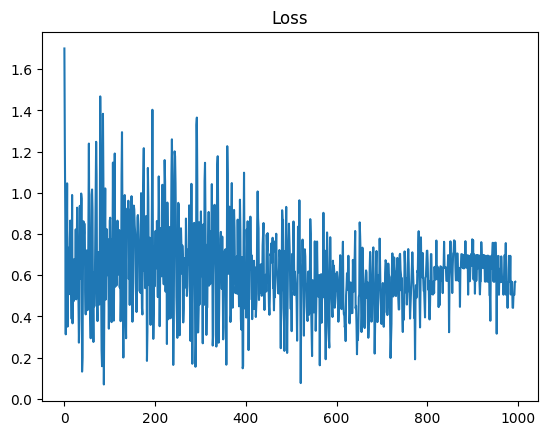

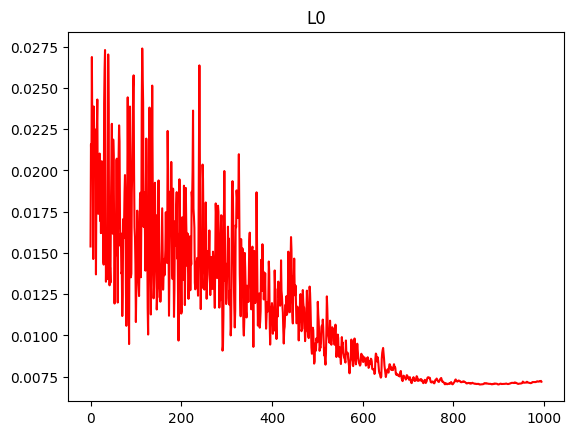

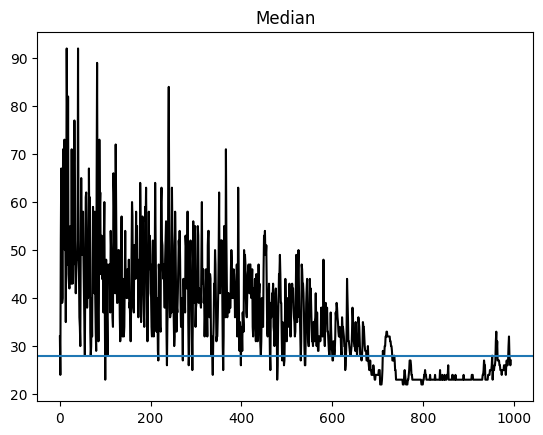

In [ ]:
import matplotlib.pyplot as plt

start_iter = 5
plt.figure()
plt.plot(stats['stats'][0][start_iter:])  # loss
plt.title('Loss')
plt.figure()
plt.plot(stats['stats'][1][start_iter:], 'r')  # l0
plt.title('L0')
plt.figure()
medians = stats['stats'][2][start_iter:]
plt.plot(medians, 'k')  # median
plt.axhline(np.median(distances))
plt.title('Median')